In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import QRC_construction.IntuitionTools as IT
import QRC_construction.Optimization as OP

%matplotlib inline

# Quantum Reservoir Computing (Notebook B)

### Overview 
1. Intuition behind QRC
2. QRC on Classical Datasets
3. QRC on Quantum Datasets
4. Performance analysis

- Annexe A: QRC pipeline
- Annexe B: The 6 types of quantum reservoir used
- Annexe B: QRC using a "bottum-up" appraoch
- Annexe C: Noise as ressource

_Author: Alexandra Golay_

----
----
----

# 1. Intuition behind QRC

Quantum Reservoir Computing (QRC) is believed to have great potential in the NISQ era for predicting nonlinear time series. Why? What's the intuition behind it? What are the parameters to tune in order to have the best perdictions possible? Does it work better on classical datasets or quantum ones? That's some of the questions we'll encounter around through this notebook.


The goal of this first part (_Intuition behind QRC_) is to make a small reminder of what a linear regression is, what it demands to make good prediction, and how a quantum system such as a quantum circuit can serve as a reservoir.

---
---

## 1.1. Linear Regression (small reminder)

### Problem setting

We observe a one-dimensional time series  
$y(t) \in \mathbb{R}$ for $t = 0, 1, \dots, T-1$.

The values  
$y(0), y(1), \dots, y(T-1)$  
constitute the available dataset.

Our goal is to predict future values of the time series:
$$
\hat{y}(T), \quad \hat{y}(T+1), \dots
$$


#### Autoregressive linear regression model

We fix an **autoregressive order** $n \ge 1$ (we personnally prefer to call it a **sliding window size**, which better connects to QRC).

At time $t$, we construct the feature vector
$$
x_t =
\begin{pmatrix}
y(t-1) \\
y(t-2) \\
\vdots \\
y(t-n) \\
1
\end{pmatrix}
\in \mathbb{R}^p.
$$

The linear regression model is defined as
$$
\hat{y}(t) = w^\top x_t,
$$
where $w \in \mathbb{R}^p$ is a vector of regression weights.

---

### TRAINING PHASE

During training, only **true values** of the time series are used to
construct the feature vectors.

We define the design matrix $X$ and target vector $Y$ as
$$
X =
\begin{pmatrix}
x_{n-1}^\top \\
x_n^\top \\
\vdots \\
x_{T-1}^\top
\end{pmatrix},
\qquad
Y =
\begin{pmatrix}
y(n-1) \\
y(n) \\
\vdots \\
y(T-1)
\end{pmatrix}.
$$

The regression weights are obtained by solving the least-squares problem,
which yields the closed-form solution
$$
w = (X^\top X)^{-1} X^\top Y.
$$

Here notice that we used a simple linear regression, but it's also totally possible to use a Ridge Regression at that point. The only difference will be that instead of computing w as $w = (X^\top X)^{-1} X^\top Y$, we will compute w as $w = (X^\top X + \lambda I)^{-1} X^\top Y$, where $\lambda$ is a regularization parameter.

### PREDICTION PHASE (autoregressive)

After training, predictions are generated **autoregressively**.

1. Using the last available true values, we form
$$
x_T = \bigl(y(T-1), y(T-2), \dots, y(T-n), 1 \bigr)^\top
$$
and compute
$$
\hat{y}(T) = w^\top x_T.
$$

2. To predict the next step, we construct
$$
x_{T+1} =
\bigl(\hat{y}(T), y(T-1), \dots, y(T-n+1), 1 \bigr)^\top
$$
and compute
$$
\hat{y}(T+1) = w^\top x_{T+1}.
$$

3. This process is repeated recursively. At each step, previously
predicted values are fed back into the feature vector to obtain future
predictions:
$$
\hat{y}(T+k) = w^\top x_{T+k},
\qquad k \ge 1.
$$

This procedure is what we call **autoregressive (or autonomous) prediction** (Emma and I also like to call it the noncheating prediction).


---

### Case n = 1.

<img src="img/LR_n_1.jpeg" alt="LR (n=1)" width="500"
     style="float:right; margin-right:150px; margin-bottom:10px;" />

Let's take $n = 1$. Then $x_{T}^\top = \begin{bmatrix}
y(T-1) & 1
\end{bmatrix}$ and we will have:

$Y = \begin{pmatrix}
y(1) \\ y(2) \\... \\ y(T-1)
\end{pmatrix}, \quad X = \begin{pmatrix}
x_{1}^\top \\ x_{2}^\top \\... \\ x_{T-1}^\top
\end{pmatrix} = \begin{pmatrix}
y(0) & 1 \\ y(1) & 1 \\... \\ y(T-2) & 1
\end{pmatrix},$

$\quad w = (X^\top X)^{-1}X^\top Y = \begin{pmatrix}
w_1 \\ w_0
\end{pmatrix}$.


and the prediction will be:

- $\hat{y}(T) = x_{T}^\top w = w_1 y(T-1) + w_0 $.
- $\hat{y}(T+1) = x_{T+1}^\top w = w_1 \hat{y}(T) + w_0 $.
- ...


### Case n = 2.

<img src="img/LR_n_2.jpeg" alt="LR (n=2)" width="500"
     style="float:right; margin-right:100px; margin-bottom:10px;" />

If we take n = 2 instead, then:

$x_{T}^\top = \begin{bmatrix}
y(T-1) & y(T-2) & 1
\end{bmatrix}$ and we will have:

$Y = \begin{pmatrix}
y(2) \\ y(3) \\... \\ y(T-1)
\end{pmatrix}, \quad X = \begin{pmatrix}
x_{2}^\top \\ x_{3}^\top \\... \\ x_{T-1}^\top
\end{pmatrix} = \begin{pmatrix}
y(1) & y(0) & 1 \\ y(2) & y(1) & 1 \\... \\ y(T-2) & y(T-3) & 1
\end{pmatrix},$  

$w = (X^\top X)^{-1}X^\top Y = \begin{pmatrix}
w_2 \\ w_1 \\ w_0
\end{pmatrix}$.


the prediction will then be:

- $\hat{y}(T) = x_{T}^\top w = w_2 y(T-1) + w_1 y(T-2)+ w_0$.
- $\hat{y}(T+1) = x_{T+1}^\top w = w_2 \hat{y}(T) + w_1 y(T-1) + w_0$.
- ...



### What does this strange $I$ circle stands for?

The circle labeled with an $I$ represents a **feature map** applied to the inputs. In the case of simple linear regression (LR), this feature map is the **identity map**.  
Applying the identity means that the inputs are left unchanged:
$$
\phi_{\mathrm{LR}}(x) = I(x) = x.
$$
As a consequence, the feature vector used by the regression model is simply composed of the past input values themselves (e.g. past values of the time series in an autoregressive model). No transformation, expansion, or internal dynamics are introduced. In QRC, this identity map is replaced by a **non-trivial transformation**:
$$
\phi_{\mathrm{QRC}} : x \mapsto z.
$$
Here, the input vector $x$ is first encoded into the state of a quantum system, which then evolves under a fixed quantum dynamics. The resulting quantum state is finally measured on some chosen bases, producing a vector of features $z$. A crucial difference with linear regression is that the dimension of the feature vector can increase:
$$
\dim(z) \ge \dim(x),
$$
and in practice often $ \dim(z) \gg \dim(x). $ This feature expansion allows the subsequent linear readout to model nonlinear and temporal correlations present in the data, **even though the readout itself remains linear**. When can such an implementation be useful? That's what we will explore next.


---
---

## 1.2. What type of functions a simple LR is good at predicting?

From previous part (Emma's part; see notebook A), we can see that any function of the form $y(t) = a_n y(t-1) + a_{n-1} y(t-2)+ ... + a_1 y(t-n) + a_0$ can be fully recovered by a simple linear regression, as long as the window size $n$ and the training dataset $t$ are large enough, i.e. $n \geq m $ (so that $X$ has all the necessary information) and $t \gg 2n$ (so that $X$ is invertible). 

The weight matrix $w$ will then simply correspond to the coefficients of the function:

$w = \begin{pmatrix}
w_n \\ w_{n-1} \\ ... \\ w_0
\end{pmatrix} = \begin{pmatrix}
a_n \\ a_{n-1} \\ ... \\ a_0
\end{pmatrix}$.

Any recursive time serie which only exhibits linear dependency to past values can thus be reconstructed perfectly in theory. 

---

#### 1.2.1. Example one: **Linear** Time Series Prediction

Let's illustrate it with a simple example. We take:

$$y(t) = y(t-1) - y(t-2) + 4, \quad t \geq 2 \quad \quad \quad \textnormal{with initial conditions:} \quad y(0) = 0, \quad y(1) = 1$$

The coefficient matrix $c$ associated to this function can be written as $c = \begin{pmatrix}
1 \\ -1 \\ 4
\end{pmatrix}$. Thus the ideal weighted matrix $w$ we aim to recover is of the form $w = c = \begin{pmatrix}
1 \\ -1 \\ 4
\end{pmatrix}$.

We take a window of size $n = 2$ and a training set of size $T_{train} = 10$ (minimal value so that $X$ is invertible, i.e. full rank; value found by iterating from $T_{train} = 1$, and continuing until reaching a perfect recovery at $T_{train} = 10$). We then test our model on a test set of size $T_{test} = 50$ (normally the test set is way smaller than the training set, but here it's to put in evidence that indeed we have a perfect recovery, and can thus predict infinitely many values with a perfect accuracy).


In [2]:
def f1(T, init):
    '''
    T : total size (of the dataset)
    init : (y(0), y(1))
    '''
    # Generate the dataset y(t) = y(t-1) - y(t-2) + 4
    y_true = np.zeros(T)
    y_true[0], y_true[1] = init

    for i in range(2, T):
        y_true[i] = y_true[i-1] - y_true[i-2] + 4

    true_coeffs = np.array([1, -1, 4])

    return y_true, true_coeffs

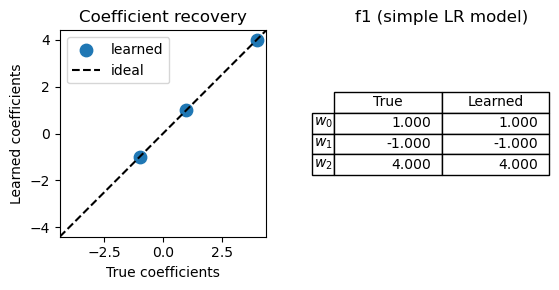

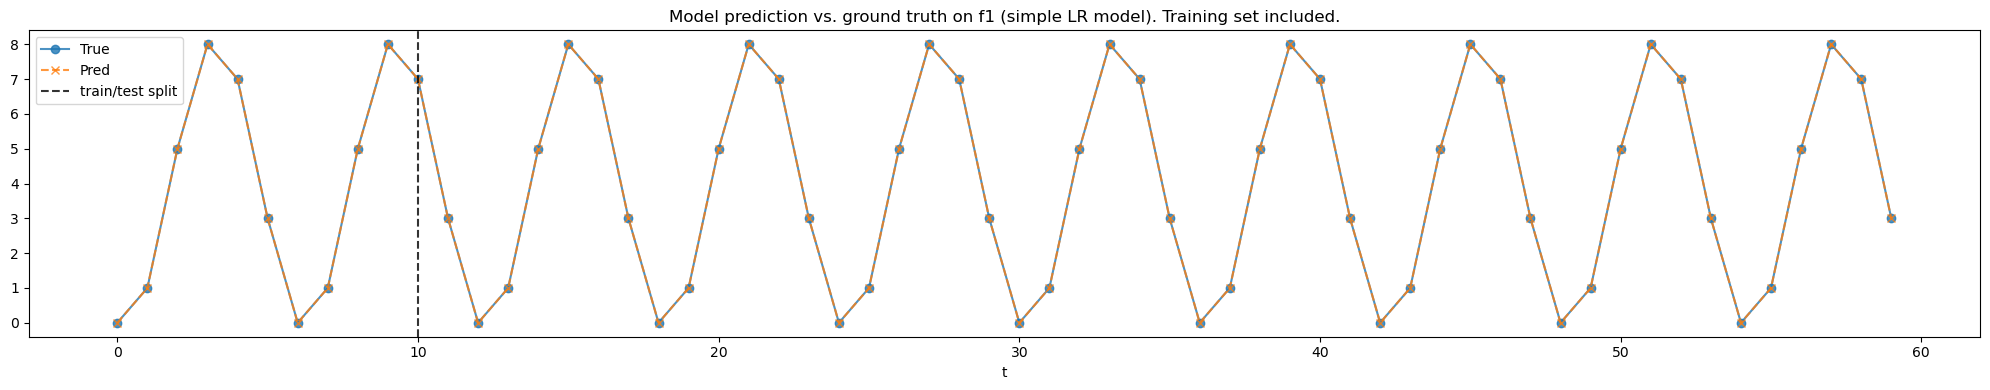

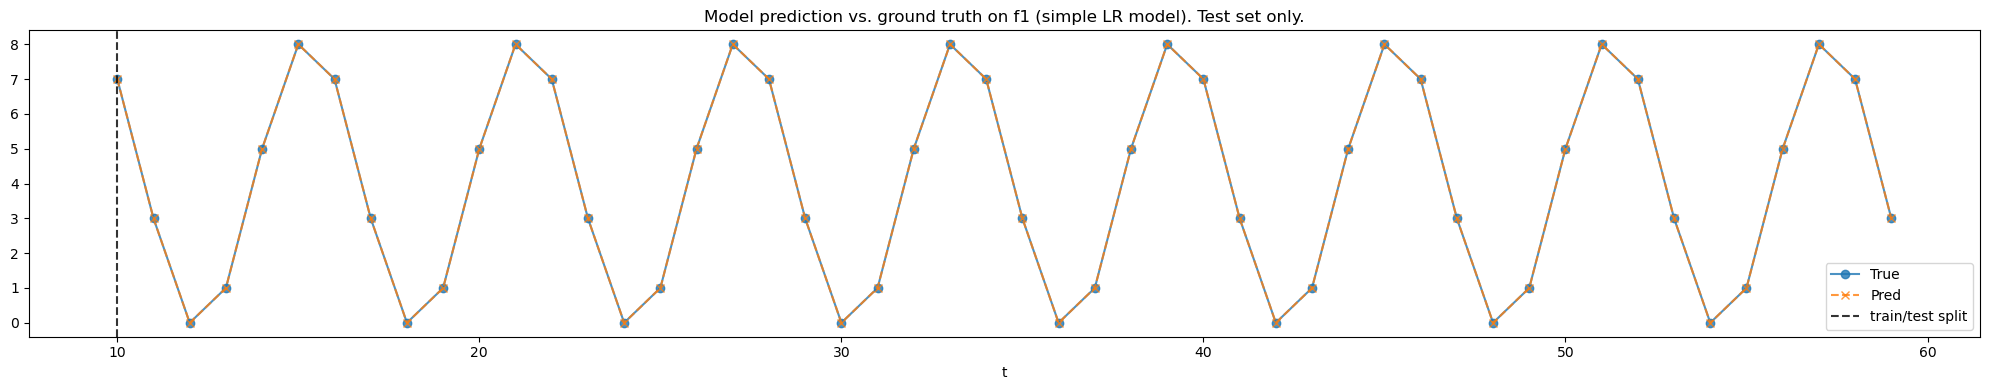

NRMSE: 8.940755379445225e-14


In [6]:
f1_T_train, f1_T_test = 10, 50
f1_true, f1_true_coeffs = f1(T = f1_T_train + f1_T_test, init = (0, 1)) 
f1_pred, f1_w = IT.LR(f1_true, f1_true_coeffs, t_train = f1_T_train, t_test = f1_T_test, n = 2, title = "f1", improved = False)
f1_nrmse_err = OP.NRMSE(f1_true[f1_T_train+1:], f1_pred[f1_T_train+1:])
print("NRMSE:", f1_nrmse_err)

We observe that: 

- $w = c = \begin{pmatrix}
1 & -1 & 4
\end{pmatrix}^\top $ (weight matrix equal to coefficient matrix)

- $\hat{y}(t) = y(t) \quad \forall t \geq 0$ (predicted time serie equal to true time serie)

- $NRMSE \approx 0$


This means that the function:

$y(t) = y(t-1) - y(t-2) + 4, \quad t \geq 2 \quad \quad \quad \textnormal{with initial conditions:} \quad y(0) = 0, \quad y(1) = 1$

is reconstructed perfectly, as expected.

---

#### Small parenthesis: what does NRMSE stand for?

NRMSE stands for **Normalized Root Mean Square Error**.  
It is a commonly used error measure to quantify the discrepancy between a
predicted time series $\hat{y}(t)$ and the true time series $y(t)$.

For a one-dimensional time series of length $T$, the RMSE is defined as
$$
\mathrm{RMSE}
= \sqrt{\frac{1}{T}\sum_{t=1}^{T}\bigl(\hat{y}(t) - y(t)\bigr)^2}.
$$

The NRMSE is obtained by normalizing the RMSE by the standard deviation of
the target signal:
$$
\mathrm{NRMSE}
= \frac{\mathrm{RMSE}}{\sigma_y}
= \frac{
\sqrt{\frac{1}{T}\sum_{t=1}^{T}\bigl(\hat{y}(t) - y(t)\bigr)^2}
}{
\sqrt{\frac{1}{T}\sum_{t=1}^{T}\bigl(y(t) - \bar{y}\bigr)^2}
},
$$
where $\bar{y}$ is the empirical mean of the time series.

This normalization makes the error **dimensionless** and **scale-invariant**,
which allows fair comparison of prediction performance across different time
series or experimental settings (which is wished in our case, since we will benchmark the efficiency of QRC on different time series).

NRMSE is particularly well suited for time series prediction because it:

- penalizes large errors more strongly than small ones;
- accounts for the intrinsic variability of the signal.

Hence that's the standard error measure we use in the whole project.

As a rule of thumb:

- $0 \le \mathrm{NRMSE} < 0.1$ : excellent prediction (almost perfect tracking);
- $0.1 \le \mathrm{NRMSE} < 0.3$ : very good prediction;
- $0.3 \le \mathrm{NRMSE} < 0.5$ : acceptable prediction;
- $0.5 \le \mathrm{NRMSE} < 1$ : poor prediction;
- $\mathrm{NRMSE} \ge 1$ : prediction no better than using the mean of the signal.

An NRMSE larger than $1$ indicates that the prediction error is larger than the
typical fluctuations of the time series, meaning that the model fails to
capture the underlying dynamics.



---

#### 1.2.2. Example two: **Non-Linear** Time Series Prediction


What about a time series with at least one nonlinear dependency to a past value? Is a simple linear regression able to reconstruct it?

For a better comparison, let's take the time serie as in [example 1.2.1.](#1.2.1.-example-one:-Linear-Time-Series-Prediction), but we add one extra non-linear term. We take:

$$y(t) = y(t-1) - y(t-2) + 4 + \alpha \cos(y(t-1)), \quad t \geq 2 \quad \quad \quad \textnormal{with initial conditions:} \quad y(0) = 0, \quad y(1) = 1$$

Here note that we've just added the extra non-linear term $\alpha \cos(y(t-1))$. The coefficient matrix $c$ can thus be expressed as $$c = \begin{pmatrix}
1 \\ -1 \\ 4 \\ \alpha
\end{pmatrix}$$

In [7]:
def f2(T, alpha):
    # Generate the dataset y(t-1) - 2y(t-2) + 4 + alpha*cos(y(t-1)), with y(0) = 0 and y(1) = 1
    y_true = np.zeros(T)
    y_true[0] = 0
    y_true[1] = 1

    true_coeffs = np.array([1, -1, 4, alpha])

    for i in range(2, T):
        y_true[i] = y_true[i-1] - y_true[i-2] + 4 + alpha*np.cos(y_true[i-1])

    return y_true, true_coeffs

Let's be more generous than before and say we have access to $T_{train} = 600$ training datas. We aim to predict the next $T_{test} = 10$ values only. If $\alpha = 0$, we have the same function as in [example 1.2.1.](#1.2.1.-example-one:-Linear-Time-Series-Prediction), and thus we have a perfect reconstruction. How about other values of $\alpha$? We aim to find the worst one, i.e. the $\alpha$ such as the NRMSE is the highest. We test test this for a range of values of $\alpha = \{0, 1, 2, \ldots, 19\}$.

In [8]:
def f2_find_max_NRMSE(t_train, t_test, range_alpha = 20):
    """
    Parameters:
    t_train : minimal training size (of the dataset)
    t_test : test size (of the dataset)
    range_alpha : range of alpha we want to test

    Returns:
    error_max, alpha_error_max (worst NRMSE and corresponding alpha)
    """
    filename = f"datas/QRC_intuition/f2_MAX_NRMSE_train" + str(t_train) + "_test" + str(t_test) + "_range_alpha" + str(range_alpha) +".png"
    error = []
    alpha_vals = []
    error_max = 0
    alpha_error_max = 0
    for a in range(20):
        alpha = a*20/range_alpha
        alpha_vals.append(alpha)
        y_true, true_coeffs = f2(T = t_train + t_test, alpha = alpha)
        y_pred = IT.LR(y_true, true_coeffs, t_train = t_train, t_test = t_test, n = 2, title = "f2_a_" + str(alpha), plotting = False, improved = False)[0]
        nrmse = OP.NRMSE(y_true[t_train+1:], y_pred[t_train+1:]) # NRMSE 
        error.append(nrmse)
        if nrmse > error_max:
            error_max = nrmse
            alpha_error_max = alpha

    alpha_vals = np.asarray(alpha_vals)
    error = np.asarray(error)

    IT.plot_param_vs_NRMSE(alpha_vals, error, filename)

    return error_max, alpha_error_max

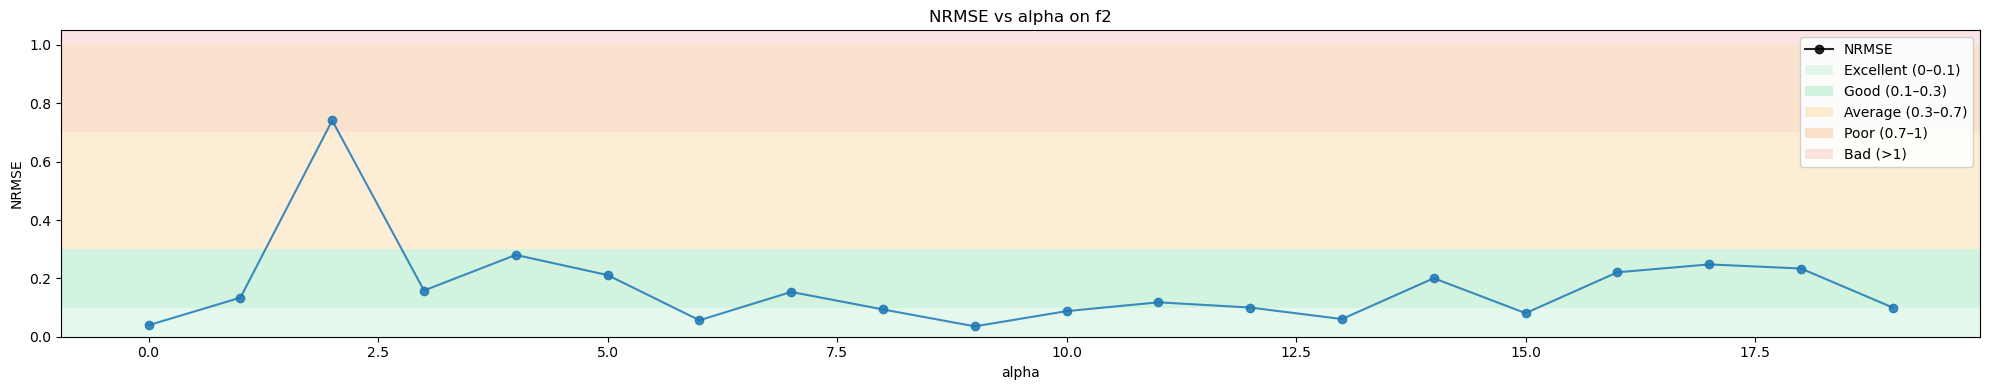

Worst alpha: 2.0 , with NRMSE= 0.7410913293880173


In [9]:
f2_T_train = 600
f2_T_test = 10
f2_nrmse_lr, alpha_error_max = f2_find_max_NRMSE(t_train=f2_T_train, t_test=f2_T_test, range_alpha = 20)
print(f"Worst alpha:", alpha_error_max, ", with NRMSE=", f2_nrmse_lr)

According to the plot above, the worst NRMSE arrises for $\alpha = 2.0$, which gives a NRMSE of 0.74. Let's see what are the coefficients of the weight matrix $w$ (we expect that the coeffs of $w$ are no longer equal to the coeffs of $c$) and how does the predicted time $\hat{y}(t)$ look like.

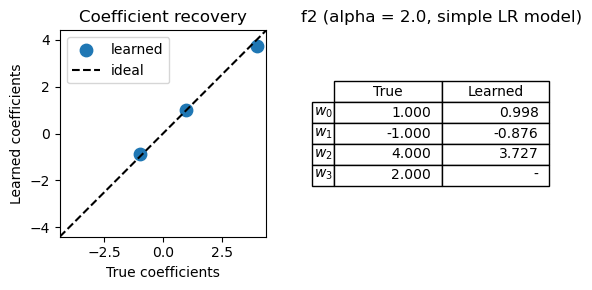

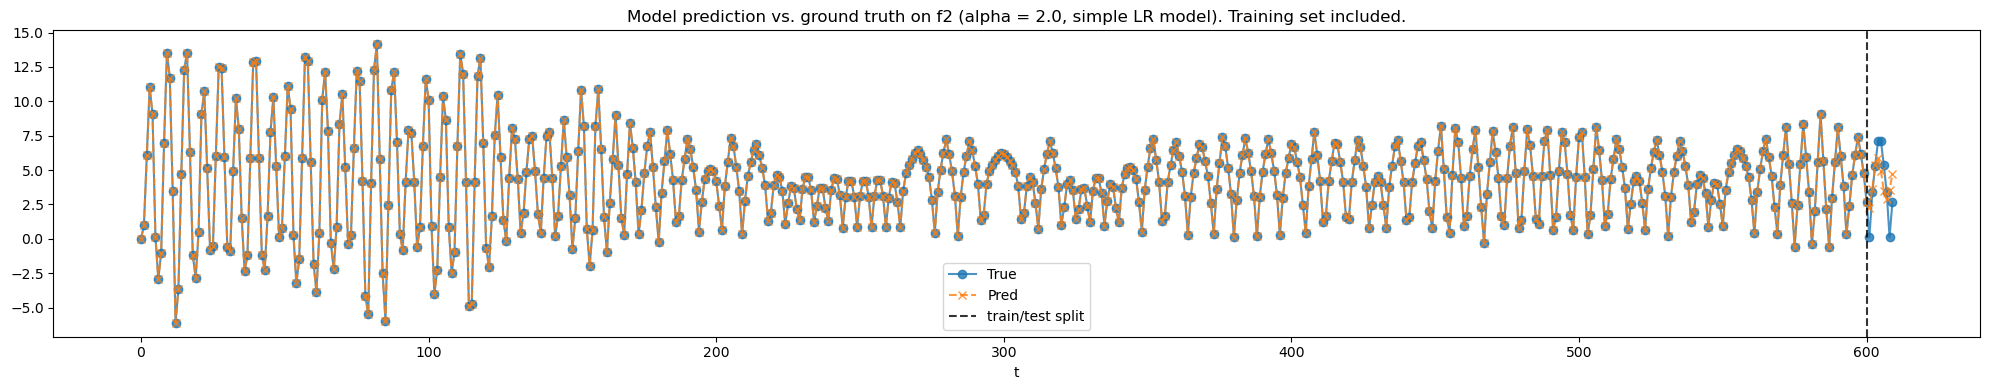

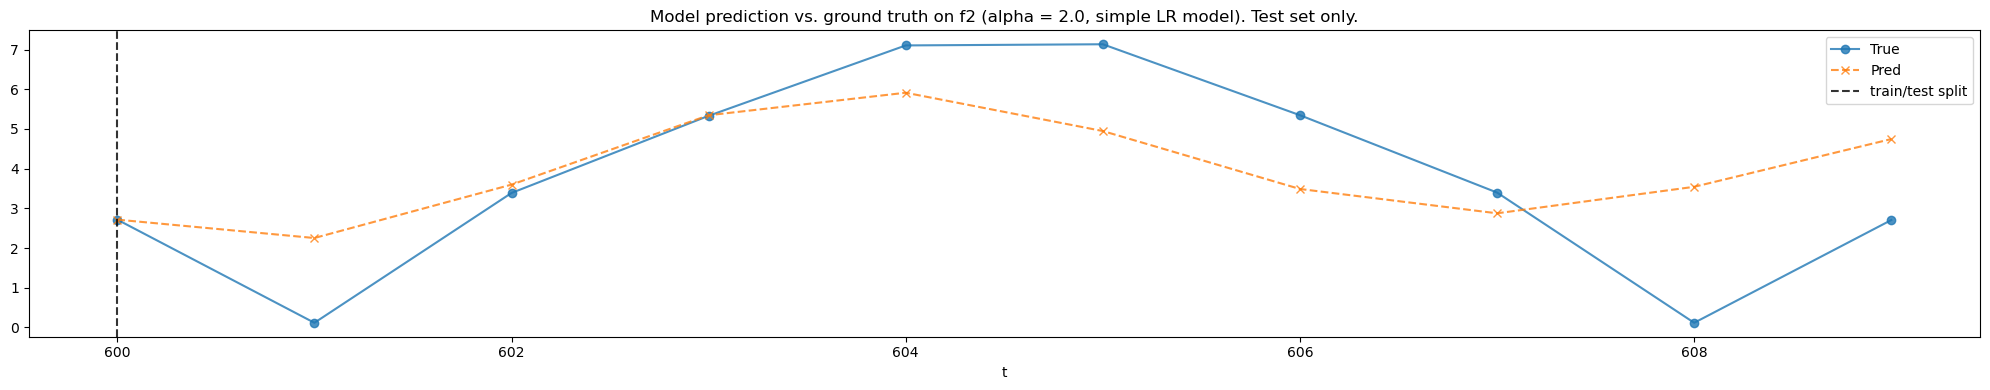

NRMSE: 0.7410913293880173


In [10]:
f2_true, f2_true_coeffs = f2(T = f2_T_train + f2_T_test, alpha = alpha_error_max)
f2_pred, f2_w = IT.LR(f2_true, f2_true_coeffs, t_train = f2_T_train, t_test = f2_T_test, n = 2, title = f"f2_a_{alpha_error_max}", improved = False)
f2_nrmse_err = OP.NRMSE(f2_true[f2_T_train+1:], f2_pred[f2_T_train+1:])
print("NRMSE:", f2_nrmse_err)

We observe that the learned weight vector $w$ partially recovers the linear coefficients of the true dynamics. However, since the model ignores the additional nonlinear dependency on $y(t-1)$, it cannot represent the dynamics exactly.

As a result, the linear regression compensates for this missing nonlinearity by adjusting the remaining linear coefficients. This leads to a distortion of the estimated weights, which no longer correspond exactly to the true linear terms.

Consequently, the predictions capture the overall trend of the time series but fail to reproduce it perfectly.

#### What about increasing the window size n?

We could be tempted to think that even though adding y(t-3) to the feature vector won't replace the missing nonlinear dependency on $y(t-1)$, it will at least improve the prediction, by perhaps capturing some of the nonlinearity.

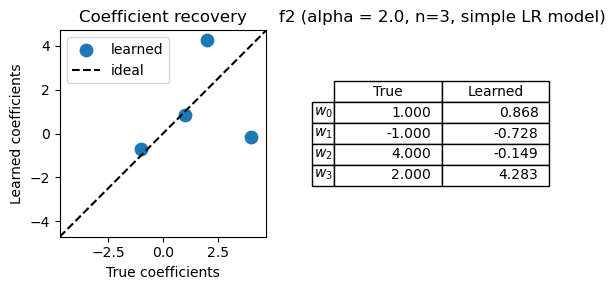

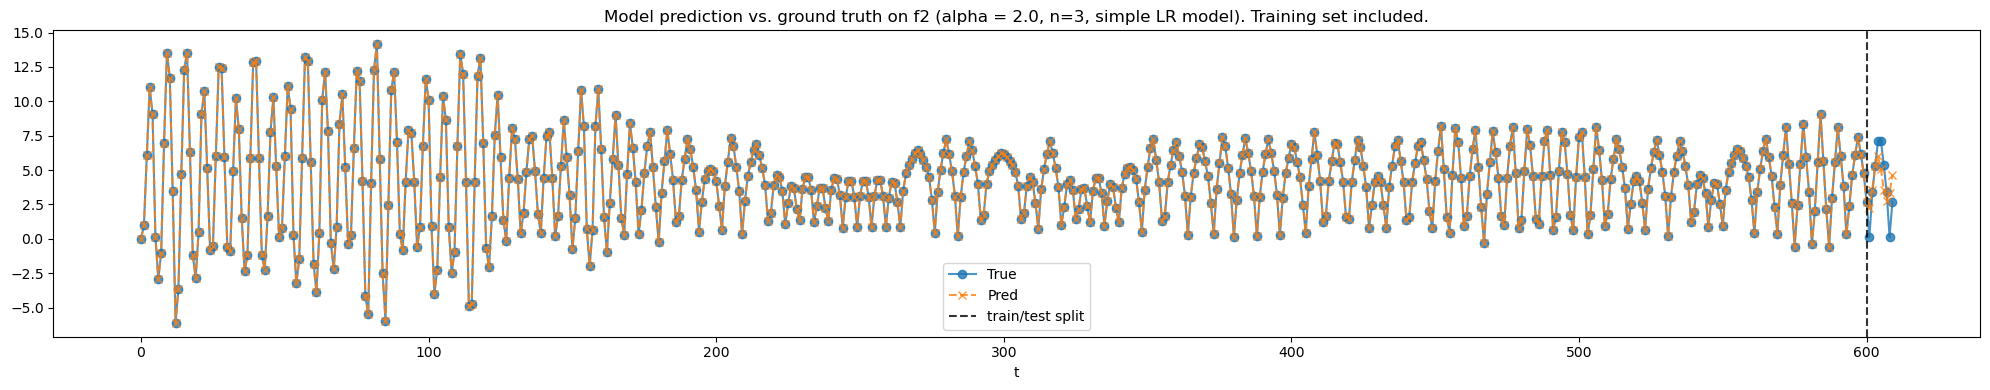

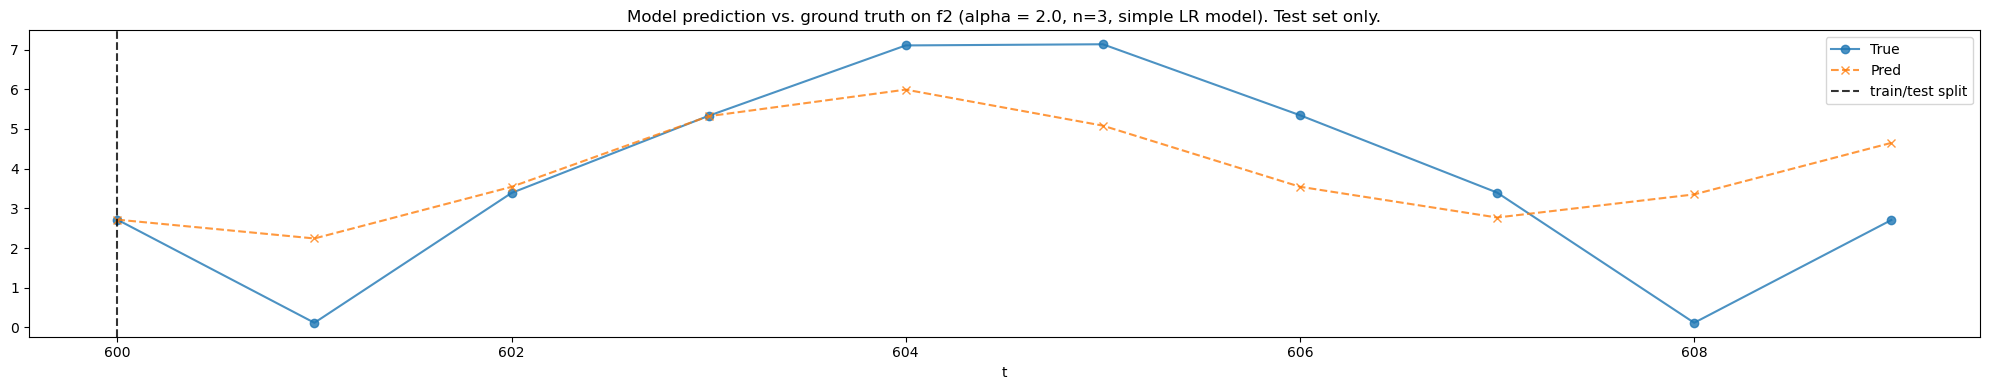

NRMSE: 0.7091304146764172


In [11]:
f2_pred_3, f2_w_3 = IT.LR(f2_true, f2_true_coeffs, t_train = f2_T_train, t_test = f2_T_test, n = 3, title = f"f2_a_{alpha_error_max}, n=3", improved = False)
f2_nrmse_err_3 = OP.NRMSE(f2_true[f2_T_train+1:], f2_pred_3[f2_T_train+1:])
print("NRMSE:", f2_nrmse_err_3)

We see that even by increasing the window size to $n = 3$ (allowing acces the more past values), the NRMSE does not improve by much (0.741 -> 0.709).

---

### 1.2.3. Can we cheat? (yes)

By comparing functions [example 1.2.1.](#1.2.1.-example-one:-Linear-Time-Series-Prediction) (linear) and [example 1.2.2.](#1.2.2.-example-two:-Nonlinear-Time-Series-Prediction) (nonlinear), we clearly see that, while a simple linear regression is all we need to recover linear dependencies to past values, it cannot find nonlinear dependencies such as $\alpha \cos(y(t-1))$, at least not with a feature vector of the form

$$x_{t}^\top = \begin{bmatrix}
y(t-1) & y(t-2) & 1
\end{bmatrix}$$

One solution is to add artificially the term $\cos(y(t-1))$ into the feature vector $x_t$, i.e.

$$x_t^\top = \begin{bmatrix}
y(t-1) & y(t-2) & 1 & \cos(y(t-1))
\end{bmatrix} $$

Now, $x_t$ has a linear dependency to terms of the form $\cos(y(t-1))$, which means that we can find $w = c = \begin{pmatrix}
1 \\ -1 \\ 4 \\ \alpha
\end{pmatrix}$.

This allow us to recover coefficient $\alpha$ of $y(t) = y(t-1) - y(t-2) + 4 + \alpha \cos(y(t-1))$, and therefore to reconstruct perfectly the entire function. 

Let's demonstrate that it works.


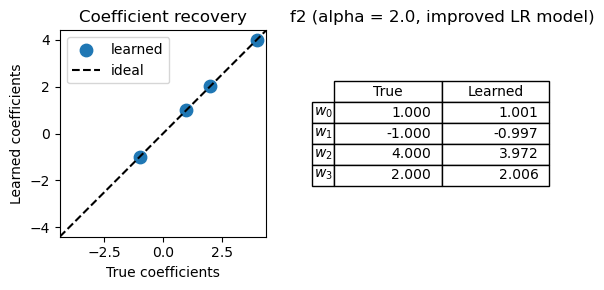

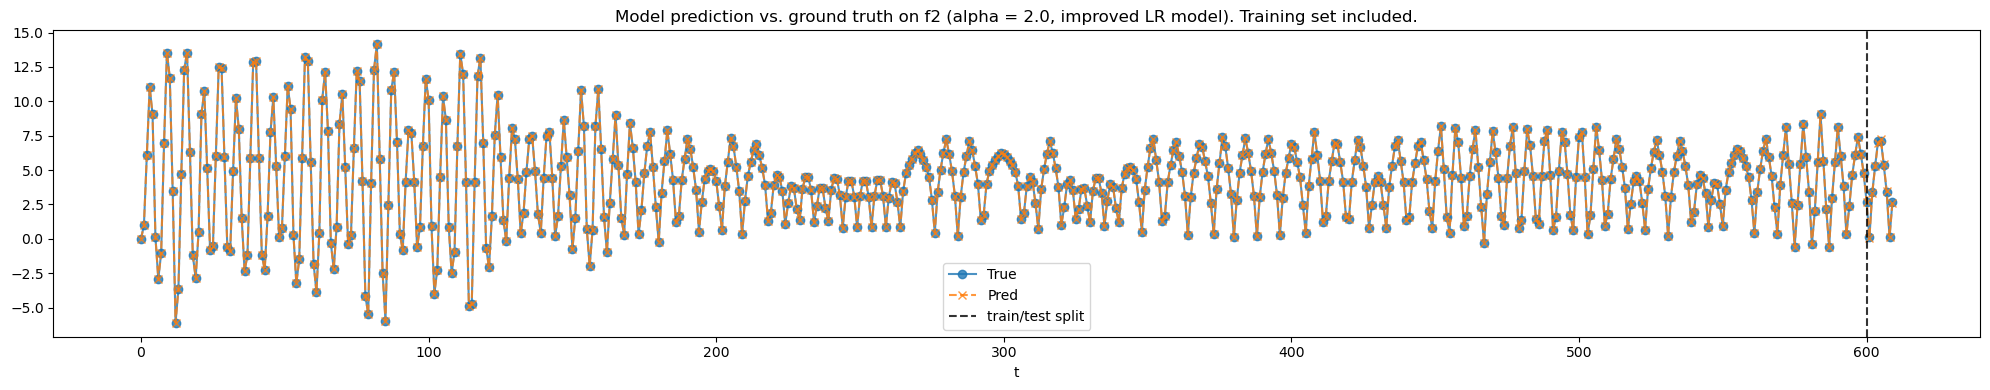

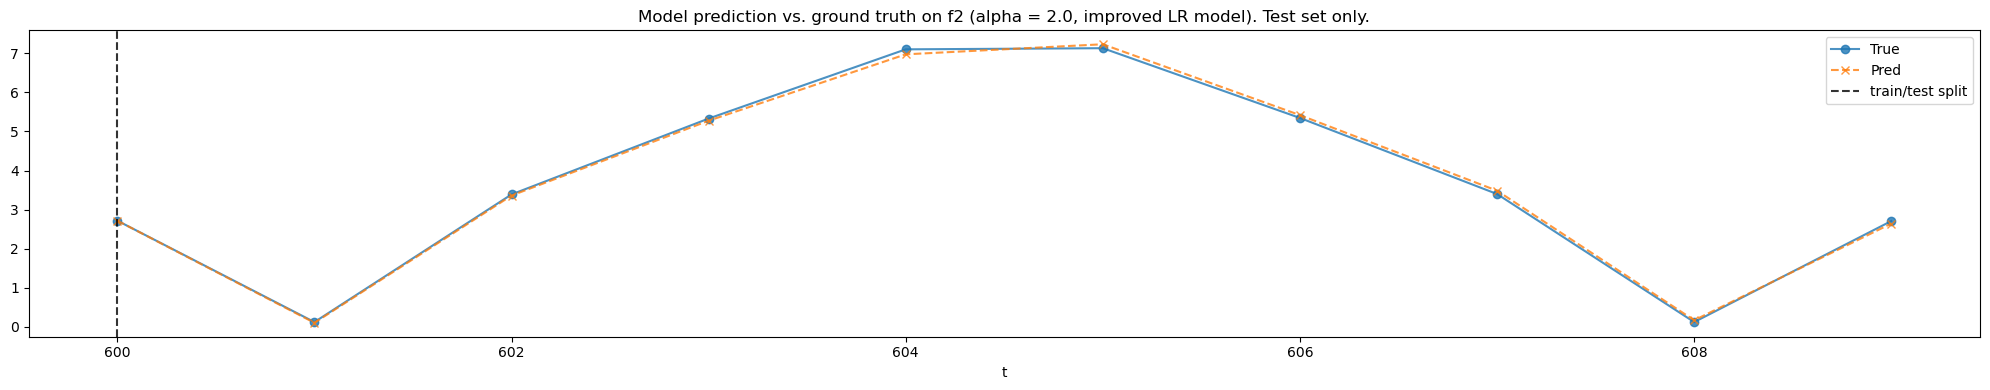

NRMSE: 0.029894223336962622


In [12]:
f2_pred_imp, f2_w_imp = IT.LR(f2_true, f2_true_coeffs, t_train = f2_T_train, t_test = f2_T_test, n = 2, title = f"f2_a_{alpha_error_max}", improved = True)
f2_nrmse_lr_imp = OP.NRMSE(f2_true[f2_T_train+1:], f2_pred_imp[f2_T_train+1:])
print("NRMSE:", f2_nrmse_lr_imp)

We observe that the NRMSE drops from $0.74$ to $0.03$, simply by adding the missing nonlinear dependency to the feature vector $x_t$. With this enriched feature set, the predicted signal $\hat{y}(t)$ becomes almost indistinguishable from the true time series $y(t)$.

However, this improvement relies on prior knowledge of the system: we explicitly knew which nonlinear dependency had to be included in $x_t$ in order to recover the original dynamics. For a generic time series $y(t)$, such information is not available. In general, we do not know whether nonlinear terms are present, nor what their precise form might be. Moreover, some time series might not even have any analytic form.

One possible approach is to use more expressive machine learning models, such as neural networks, which are capable of automatically learning nonlinear features. The main drawback of this strategy is that the training phase can become computationally expensive.

let's suppose that we are faced with time series exhibiting strong nonlinear dependencies, while long training times are not a wanted option. Is there an alternative?

This is precisely the setting in which **Quantum Reservoir Computing (QRC)** becomes relevant. QRC provides a way to generate rich nonlinear features and memory effects through a fixed quantum dynamical system, while keeping the training procedure limited to a simple linear readout. Let's now see how QRC performs on our function $f2$ with $\alpha = 2$.

---
---

## 1.3. Nonlinear time serie prediction using QRC

Now let's try to use QRC to predict the function $f2$ with $\alpha = 2$. We perform a grid search over many parameters. What are them exactly? This will will be the subject of the next notebooks. Here the idea is just to demonstrate that it _does_ exist a certain combination of parameters so that QRC method offers better prediction than a simple linear regression.


In [ ]:
f2_qr_best_params, f2_qr_worst_params = OP.find_optimal_res_sliding_window_classical_dataset(f2_true, f2_T_train, f2_T_test, nb_input_qubits = 1, 
                                                                                                sliding_window_size_range=(2,4), 
                                                                                                nb_extra_qubits_range=(0,2), 
                                                                                                seeds=[0,1], 
                                                                                                try_res_G=True,
                                                                                                try_res_MG=True,
                                                                                                try_res_D=True,
                                                                                                try_res_ISING=True,
                                                                                                try_Rz=False,
                                                                                                depths_G=[3, 10])                                                                                 

This cell is very long to run. We did it for you and saved the results in "datas/QRC_intuition/f2_datas_a_2.0_train600_test10.txt" file. You can access the results using the code from below.

In [53]:
import importlib
importlib.reload(OP)

<module 'QRC_construction.Optimization' from '/Users/alexandragolay/Documents/Pro/MA-SIQ/MA3/QRC/QRC_construction/Optimization.py'>

In [ ]:
file_path_f2 = "datas/Intuition/T600_test10.txt" 
f2_qr_best_params,f2_qr_worst_params = OP.recompute_best_worst_from_logfile(file_path_f2, f2_true, f2_T_train, f2_T_test, nb_input_qubits = 1, k=1)

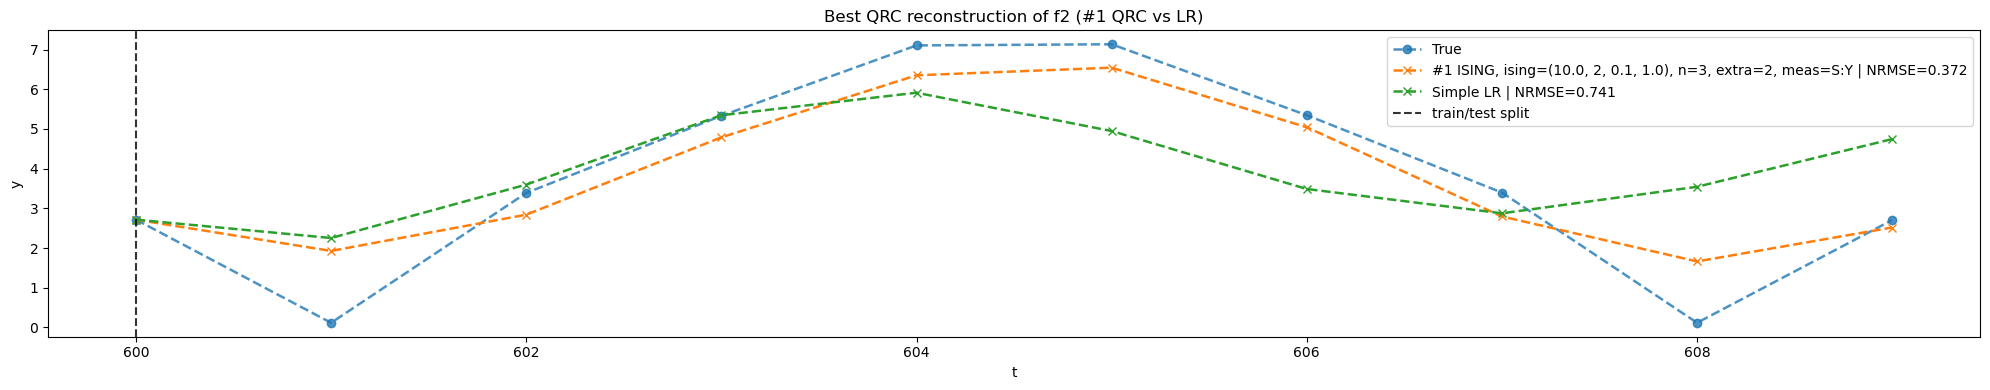

In [55]:
OP.plot_ranked_predictions(f2_qr_best_params[:1],T_train=f2_T_train,title="Best QRC reconstruction of f2 (#1 QRC vs LR)",filename="datas/QRC_intuition/f2_best_QRC_reconstruction_a_2.0_train600_test10.png", y_lr = f2_pred)

Best QRC reconstruction parameters: ISING ising=(10.0, 2, 0.1, 1.0) | seed=1 | n=3, extra=2 | meas=S:Y | time=0.90 | NRMSE=0.372

Here we see that over the best QRC reconstruction, we obtain a NRMSE of 0.372. This is an improvement over the NRMSE of 0.74 obtained with the simple linear regression. Now, let's continue to the next notebook, which will explore the QRC pipeline on classical datasets, and try to see how some parameters can affect the final prediction.

---

Altogether in the same plot:

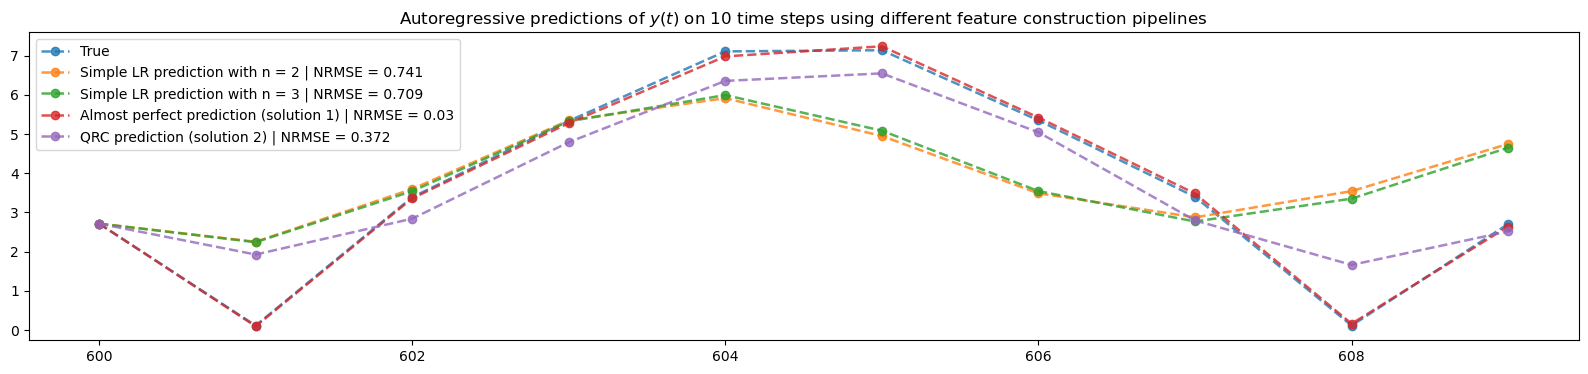

In [58]:
f3_pred_qrc = np.asarray(f2_qr_best_params[:1][0]["y_pred"]).ravel()
plt.figure(figsize=(20, 4))
t0 = 600 - 0
t_range = np.arange(t0, len(f2_true))
plt.plot(t_range, f2_true[t0:], "--o", lw=1.8, label="True", alpha=0.8)
plt.plot(t_range, f2_pred[t0:], "--o", lw=1.8, label="Simple LR prediction with n = 2 | NRMSE = 0.741", alpha=0.8)
plt.plot(t_range, f2_pred_3[t0:], "--o", lw=1.8, label="Simple LR prediction with n = 3 | NRMSE = 0.709", alpha=0.8)
plt.plot(t_range, f2_pred_imp[t0:], "--o", lw=1.8, label="Almost perfect prediction (solution 1) | NRMSE = 0.03", alpha=0.8)
plt.plot(t_range, f3_pred_qrc[t0:], "--o", lw=1.8, label="QRC prediction (solution 2) | NRMSE = 0.372", alpha=0.8)
plt.legend()
plt.title("Autoregressive predictions of $y(t)$ on 10 time steps using different feature construction pipelines")
plt.show()

---
---